# Data Import

In [23]:
import pandas as pd
import nltk
import re
import string
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS

# Ensure necessary NLTK downloads
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('maxent_ne_chunker')
# nltk.download('words')

# Load and preprocess data
train_file = '../data/train.csv'
test_file = '../data/test.csv'

df = {
    'train': pd.read_csv(train_file),
    'test': pd.read_csv(test_file)
}

In [4]:
df['train']


,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3
...,...,...,...
17302,ffd378d,"the story "" The Challenge of Exploing Venus "" ...",2
17303,ffddf1f,Technology has changed a lot of ways that we l...,4
17304,fff016d,If you don't like sitting around all day than ...,2
17305,fffb49b,"In ""The Challenge of Exporing Venus,"" the auth...",1


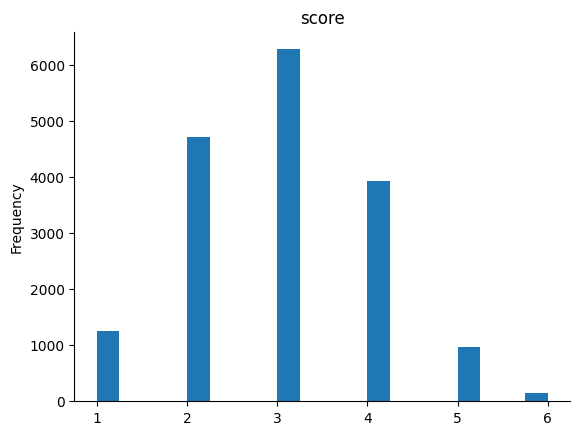

In [5]:
# @title score

from matplotlib import pyplot as plt
df['train']['score'].plot(kind='hist', bins=20, title='score')
plt.gca().spines[['top', 'right',]].set_visible(False)

## Train Test Split

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['train'], df['train']['score'], test_size=0.2, random_state=42, stratify=df['train']['score'])

# Pre Processing

## Removing Extra Things

Preprocessing train data...
Preprocessing test data...


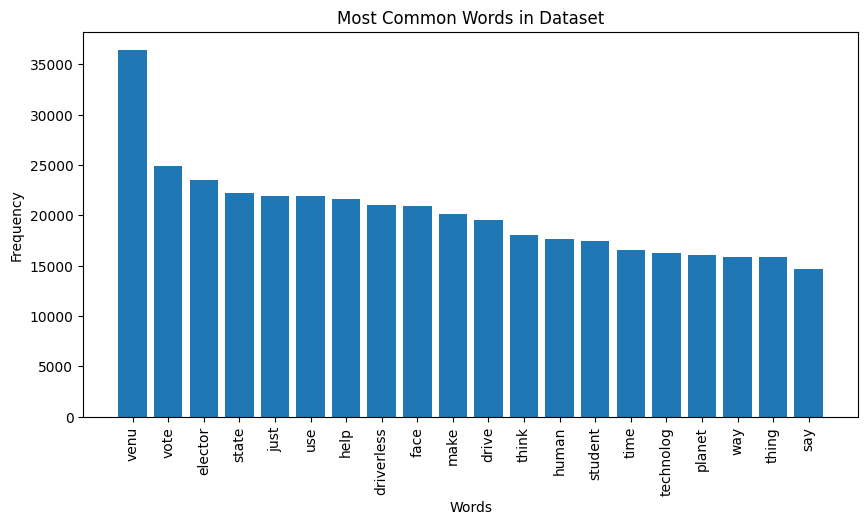

In [9]:

stopwords = nltk.corpus.stopwords.words("english")

def remove_whitespace(text):
    result = text.strip()
    return result

def comprehensive_text_preprocessing(text):
    # Lowercase and remove HTML tags
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenization
    words = word_tokenize(text)

    # Remove stop words
    words = [word for word in words if word not in ENGLISH_STOP_WORDS]
    words = [word for word in words if word not in stop_words]

    # Stemming and Lemmatization
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    stemmed_words = [stemmer.stem(word) for word in words]
    lemmatized_words = [lemmatizer.lemmatize(word) for word in stemmed_words]

    # Rejoin words for vectorization
    clean_text = ' '.join(lemmatized_words)

    return clean_text

def preprocess_data(dataframe, text_column):
    # Apply comprehensive preprocessing to the specified text column
    dataframe[text_column] = dataframe[text_column].apply(comprehensive_text_preprocessing)
    return dataframe

# Assuming 'full_text' is the column with text data to preprocess
for key in df:
    print(f"Preprocessing {key} data...")
    df[key] = preprocess_data(df[key], 'full_text')

# Extract preprocessed texts from both train and test dataframes
texts = pd.concat([df['train']['full_text'], df['test']['full_text']])

# Word Frequency Visualization
all_words = [word for text in texts for word in nltk.word_tokenize(text)]
word_freqs = Counter(all_words)
most_common_words = word_freqs.most_common(20)

# Plotting
plt.figure(figsize=(10, 5))
words, counts = zip(*most_common_words)
plt.bar(words, counts)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.title('Most Common Words in Dataset')
plt.show()


## Common Words

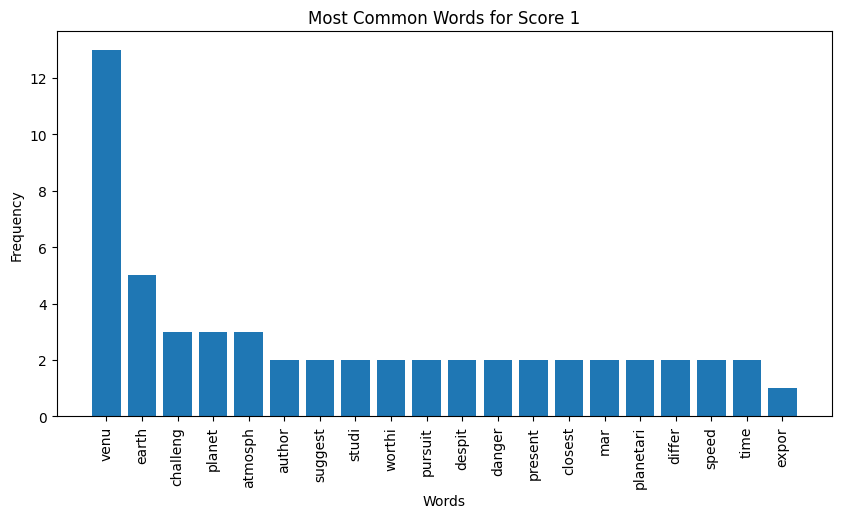

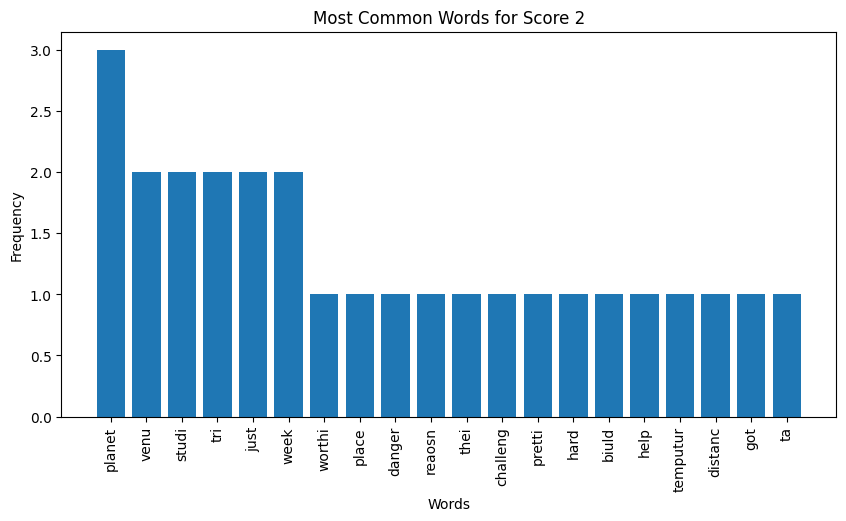

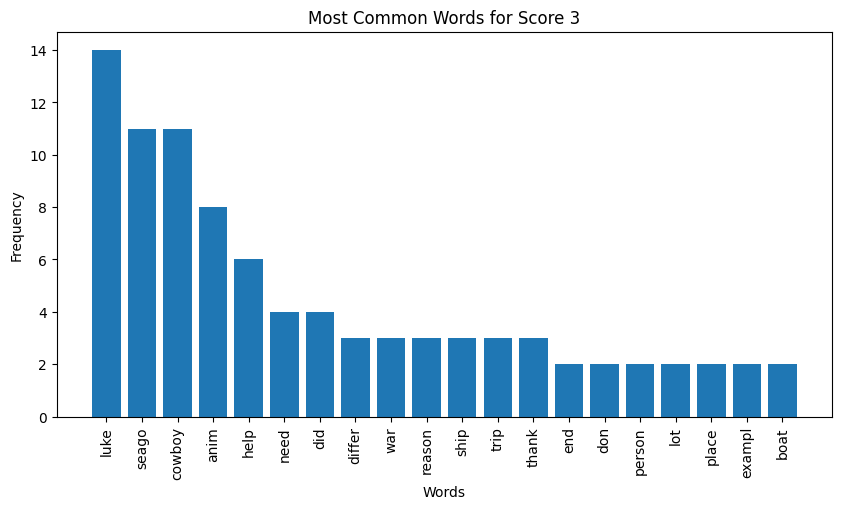

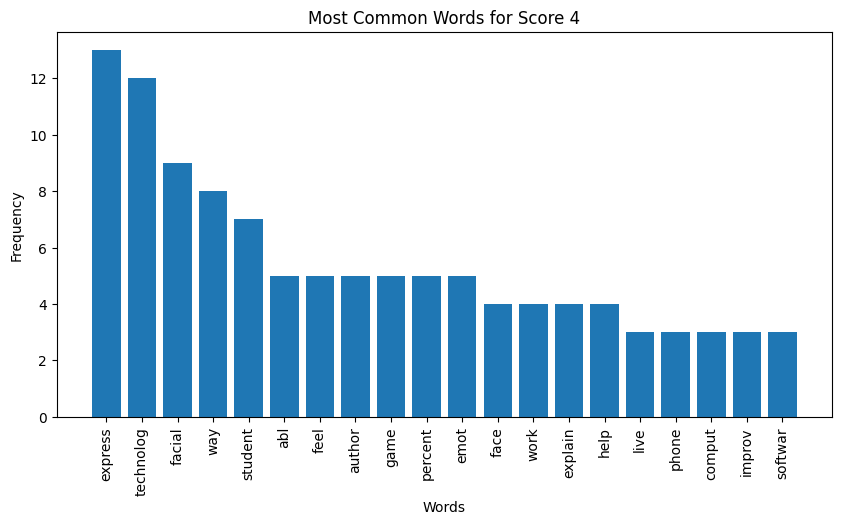

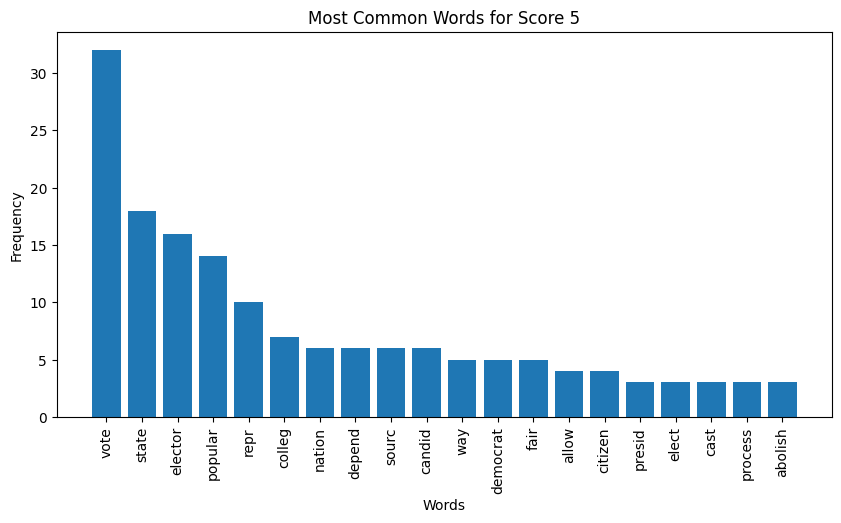

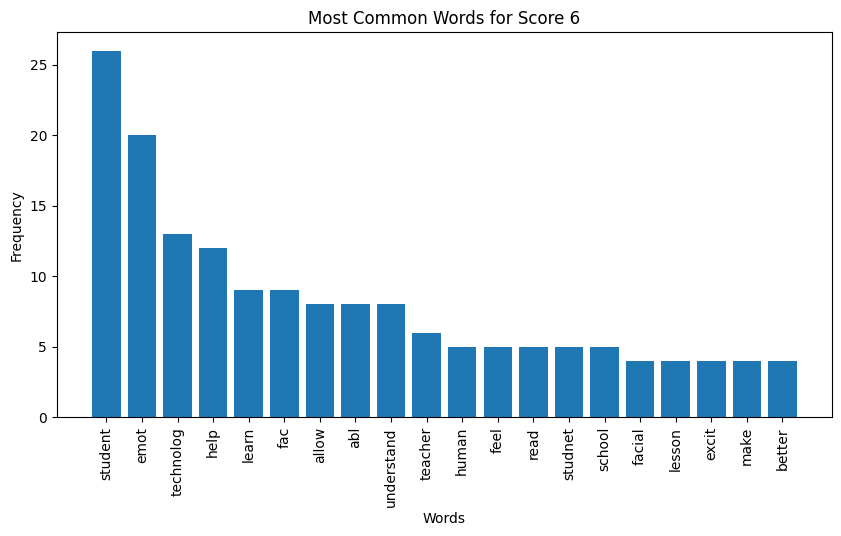

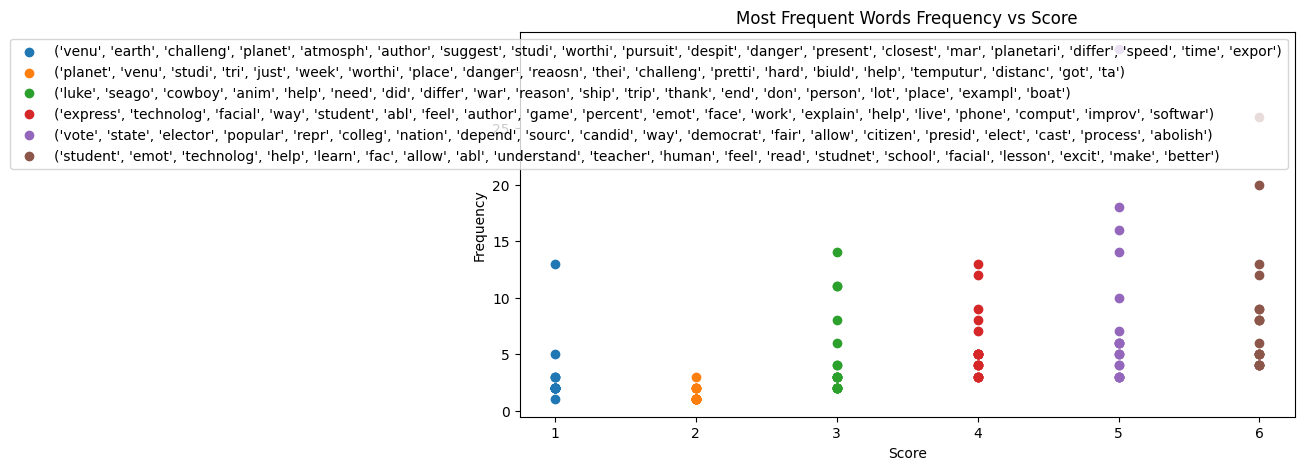

In [10]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
import matplotlib.pyplot as plt

def preprocess_and_analyze_by_score(dataframe,full_text, score):
    # Preprocess the text
    dataframe[full_text] = dataframe[full_text].apply(comprehensive_text_preprocessing)

    # Group by score
    grouped = dataframe.groupby(score)

    # Dictionary to hold word counts for each score
    score_word_freqs = {}
    scatter_data = []
    for score, group in grouped:
        all_words = []
        for text in group[full_text]:
            words = word_tokenize(text)
            word_freqs = Counter(words)
            score_word_freqs[score] = word_freqs.most_common(20)  # top 20 words for each score
            most_common_word, frequency = word_freqs.most_common(1)[0]  # Most frequent word in the essay
            scatter_data.append((most_common_word, frequency, score))  # (word, frequency, score)

    return score_word_freqs

# Apply the function
score_word_freqs = preprocess_and_analyze_by_score(df['train'], 'full_text', 'score')

# Now let's visualize the most common words for each score
for score, common_words in score_word_freqs.items():
    words, frequencies = zip(*common_words)
    plt.figure(figsize=(10, 5))
    plt.bar(words, frequencies)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)
    plt.title(f'Most Common Words for Score {score}')
    plt.show()

plt.figure(figsize=(10, 5))
for score, common_words in score_word_freqs.items():
    words, frequencies = zip(*common_words)
    plt.scatter([score] * len(words), frequencies, label=words)

plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Most Frequent Words Frequency vs Score')
plt.legend()
plt.show()

## Length vs Score


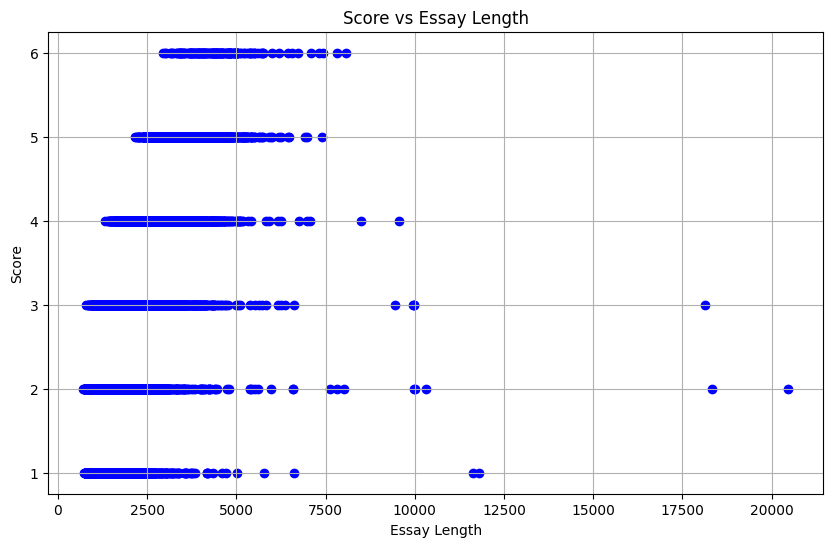

In [17]:
df['train']['essay_length'] = df['train']['full_text'].apply(len)

plt.figure(figsize=(10, 6))
plt.scatter(df['train']['essay_length'], df['train']['score'], color='blue')
plt.title('Score vs Essay Length')
plt.xlabel('Essay Length')
plt.ylabel('Score')
plt.grid(True)
plt.show()

# Linear Regression for Fun

In [28]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Vectorization using bag-of-words representation
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['train']['full_text'])
y = df['train']['score']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lin_model = LinearRegression();
lin_model.fit(X_train, y_train)

# Evaluate the model
y_pred = lin_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.909887523388493


# Word2Vec

In [30]:
#!pip install gensim
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
import nltk
#nltk.download('punkt')

# Example text data (you can replace it with your own dataset)
sentences = [
    "This is a sentence.",
    "This is another sentence.",
    "Yet another sentence."
]

# Tokenize the sentences into words
# tokenized_sentences = [nltk.word_tokenize(sentence.lower()) for sentence in sentences]

# Train the Word2Vec model
model_w2v = Word2Vec(df['train']['full_text'], vector_size=100, window=5, min_count=1, workers=4)


In [31]:
model_w2v.fit(X_train, y_train)

# Evaluate the model
y_pred = model_w2v.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

AttributeError: 'Word2Vec' object has no attribute 'fit'

In [13]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/samstep/nltk_data...
